In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from os.path import join, basename,exists
from glob import glob
from tqdm import tqdm

from obspy import read
from scipy.signal import correlate, correlation_lags, butter, filtfilt, spectrogram
from numpy.fft import fft, fftfreq, ifft, fftshift
from sklearn.preprocessing import minmax_scale
from datetime import timedelta

ac_calib = 8.2928e-05
name_dic = {'be4':'lower','a3m':'upper','ad8':'failed array'}
height_dic = {'lower-p0':0.33,'lower-p1':0.66,'lower-p2':1,'upper-p0':1.33,'upper-p1':np.nan,'upper-p2':2}

in_dir = '/home/zacharykeskinen/data/infrasound/infrasound/processed' #infrasound/banner/infrasound/processed/'
in_dir = '../../data/banner/infrasound/processed'
exists(in_dir)


# l = os.listdir(in_dir)
l = glob(os.path.join(in_dir, 'c0be4*'))
r = []
for i in l:
    i = os.path.basename(i)
    j = i[5:11]
    if j not in r:
        r.append(j)
r.sort()

wx_dir = '../../data/banner/wx/'
wx_fs = glob(join(wx_dir, '*STAND_MONTH*'))
df = pd.DataFrame()
for fp in wx_fs:
    df = df.append(pd.read_csv(fp, skiprows=3), ignore_index= True)
df.Date = pd.to_datetime(df.Date)
df = df.set_index(df.Date)
# df = df[df.index > pd.to_datetime('2021-11-01')]
df.loc[:, 'SWE_m'] = df['WTEQ.I-1 (in) ']*0.0254
df.loc[:, 'SD_m'] = df['SNWD.I-1 (in) ']*0.0254
df = df.drop_duplicates()

In [3]:
wx_dir = '../../data/banner/wx/'
wx_fs = glob(join(wx_dir, '*STAND_MONTH*'))
df = pd.DataFrame()
for fp in wx_fs:
    df = df.append(pd.read_csv(fp, skiprows=3), ignore_index= True)
df.Date = pd.to_datetime(df.Date)
df = df.set_index(df.Date)
# df = df[df.index > pd.to_datetime('2021-11-01')]
df.loc[:, 'SWE_m'] = df['WTEQ.I-1 (in) ']*0.0254
df.loc[:, 'SD_m'] = df['SNWD.I-1 (in) ']*0.0254
df = df.drop_duplicates()
# s = df[['SWE_m','SD_m']]
# s.plot(label = 'Snow Depth (m)')
# plt.ylabel('Snow Depth (m)')
# plt.axvspan(pd.to_datetime('2021-12-02'), pd.to_datetime('2021-12-09'), alpha=0.2, color='green', label = 'pre-snow')
# plt.axvspan(pd.to_datetime('2021-12-13'), pd.to_datetime('2021-12-31'), alpha=0.2, color='blue', label = 'post-snow')
# plt.axhline(0.3, color = 'black')
# plt.axhline(0.6, color = 'black')
# plt.axhline(1, color = 'black')
# plt.axhline(1.33, color = 'black', label = 'Sensor Locations')

# plt.legend()

In [4]:
def freq_filt(arr, order, fc, kind, sps = 200):
    b, a = butter(order, fc, kind, fs = sps)
    return filtfilt(b, a, arr)

def get_day(day_list, eq_day):
    day = [day for day in day_list if day == eq_day][0]
    res = {}
    ls = glob(join(in_dir, '*'+day+'*'))
    for file in ls:
                name = name_dic[basename(file).replace(day,'')[2:5]]
                if name != 'failed array':
                    tr = read(file)[0]
                    stats = tr.stats
                    sps = stats['sampling_rate']
                    assert sps == 200
                    # start = stats['starttime']
                    # end = stats['endtime']
                    channel = stats['channel']
                    name_channel = f'{name}-{channel}'
                    height = height_dic[name_channel]
                    if not np.isnan(height):
                        arr = tr.data
                        arr = arr * ac_calib
                        arr = arr - np.nanmean(arr)
                        arr_filt = freq_filt(arr, order = 2, fc = 1/10,kind = 'highpass')
                        res[height] = arr_filt
    return res

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def get_correlation_slices(arr, arr_ref, wind_len_sec, coeff_thresh =0.9, pa_thresh = 0.03, sps = 200):
        wind = int(wind_len_sec * sps)
        arr = np.reshape(arr, (wind, -1), 'F')
        arr_ref = np.reshape(arr_ref, (wind, -1), 'F')
        # now compute Pearson
        xcorr0lag = np.sum(arr*arr_ref, axis = 0)
        normalization = np.sqrt(np.sum(arr**2, axis = 0)*np.sum(arr_ref**2, axis = 0))
        Pcoeff = xcorr0lag/normalization
        condition = np.where(Pcoeff > coeff_thresh)[0]
        time_deltas = [timedelta(seconds = int(i*10)) for i in condition]

        arr = arr.reshape((Pcoeff.size, -1))
        arr = arr[condition]

        return arr[np.any(arr > pa_thresh, axis = 1)], time_deltas

def ave_slice_power(arr, sps = 200):
    power = arr**2
    power = 1/sps * np.sum(power, axis = 1)
    mean_power = np.sum(power)/power.size
    return mean_power

def slice_power(arr, sps = 200):
    power = arr**2
    power = 1/sps * np.sum(power, axis = 1)
    # mean_power = np.sum(power)/power.size
    return power

In [4]:
res = pd.DataFrame()
f_ranges = [(1,10),(10,20),(20,30),(30,40),(40,50)]
# f_ranges = [(20,30),(30,50)]
for f_low, f_high in f_ranges:
    for day in tqdm(r, unit ='days', desc = f'{f_low} to {f_high} Hz'):
#         if day == '220303' or day == '211205' or day == '220101' or day == '220313' or day == '211229':
            data = get_day(r, day)
            if data[0.33].size == 200*60*60*24:
                for height in data.keys():
                    if height == 0.33 and 1.33 in data.keys():
                        ref_height = 1.33
                    elif height == 0.33:
                        ref_height = 1
                    else:
                        ref_height = 0.33
                    arr = freq_filt(data[height], order = 2, fc = (f_low, f_high), kind = 'bandpass')
                    ref_arr = freq_filt(data[ref_height], order = 2, fc = (f_low, f_high), kind = 'bandpass')
                    #arr = freq_filt(data[height], order = 2, fc = f_high, kind = 'lowpass')
                    corr_slices, time_deltas = get_correlation_slices(arr, ref_arr, wind_len_sec= 5, coeff_thresh= 0.95, pa_thresh = np.quantile(arr, 0.9))
                    if len(time_deltas) == 0:
                        corr_slices, time_deltas = get_correlation_slices(arr, ref_arr, wind_len_sec= 5, coeff_thresh= 0.9, pa_thresh = np.quantile(arr, 0.9))
                    if len(time_deltas) > 0:
                        times = [pd.to_datetime(day,format = '%y%m%d') + time_d for time_d in time_deltas]
                        powers = slice_power(corr_slices).ravel()
                        for i in range(len(powers)):
                            #res = res.append({'Power':powers[i], 'DateTime':times[i], 'Height': height,'FreqRange':f'{f_low}-{f_high} Hz' ,'Signal': corr_slices[i,:]}, ignore_index=True)
                            res = res.append({'Power':powers[i], 'DateTime':times[i], 'Height': height,'FreqRange':f'{f_low}-{f_high} Hz'}, ignore_index=True)

# full_res = pd.DataFrame()
# dates = np.unique(res.DateTime)
# for date in dates:
#     signals = res.loc[res.DateTime == date, :]
#     if len(signals) > 2:
#         full_res = full_res.append(signals)
res.to_csv('filtered_signal.csv')

40 to 50 Hz: 100%|██████████| 104/104 [12:06<00:00,  6.98s/days]


In [8]:
res.DateTime = pd.to_datetime(res.DateTime)
res = res.set_index('DateTime')

(0.0, 2.3)

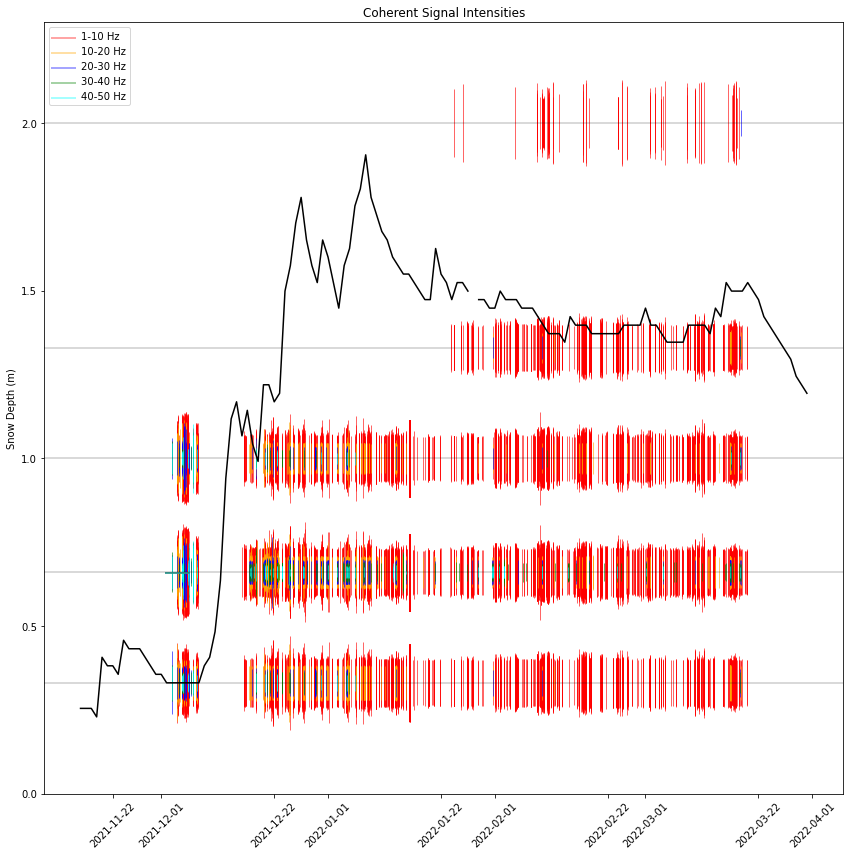

In [5]:
res = pd.read_csv('filtered_signal.csv')
res.DateTime = pd.to_datetime(res.DateTime)
# res = res.set_index('DateTime')
f, ax = plt.subplots(figsize = (12,12))
#outlier = is_outlier(res.Power.values, thresh=5)
plotting = res.copy(deep = True)
#plotting = plotting[~outlier]
s = plotting.Power
s = np.log(s)
s = minmax_scale(s, (10,10000))
#ranking_dic = {0:(255/255,204/255,204/255),1:(255/255,153/255,153/255),2:(255/255,51/255,51/255),3:(204/255,0,0),4:(102/255,0,0)}
freq_dic = {'1-10 Hz':'red','10-20 Hz':'orange','20-30 Hz':'blue','30-40 Hz':'green','40-50 Hz': 'aqua'}#, '30-50 Hz':'yellow'}
colors = [freq_dic[i] for i in plotting.FreqRange]
ax.scatter(plotting.DateTime, plotting.Height, s = s, marker = "|", alpha = 0.6, linewidth = 1, c = colors)
for k,v in freq_dic.items():
    ax.scatter(plotting.DateTime.iloc[0], plotting.Height.iloc[0], s = 1, marker = "|", alpha = 0.7, linewidth = 25, c = v, label = k)

s = df[['SWE_m','SD_m']].copy()
s.loc[s.SD_m < 0, 'SD_m'] = np.nan
s.loc[(s.SD_m < 1) & (s.index > '2022-01-01'), 'SD_m'] = np.nan 
# s.loc[:,'SD_m'] = s.loc[:,'SD_m'].rolling(5).median()
s = s[s.index>'2021-11-15']
s = s.sort_index()
ax.plot(s.index.values, s.SD_m.values, color = 'black') #, c = s.SWE_m)
ax.set_ylabel('Snow Depth (m)')
ax.axhline(0.33, color = 'black', alpha = 0.2)
ax.axhline(0.66, color = 'black', alpha = 0.2)
ax.axhline(1, color = 'black', alpha = 0.2)
ax.axhline(1.33, color = 'black', alpha = 0.2)
ax.axhline(2, color = 'black', alpha = 0.2) #, label = 'Sensor Location' )
# ax.locator_params(axis = 'x', nbins = 4)
ax.legend(loc = 'upper left')
plt.title('Coherent Signal Intensities')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.ylim(0, 2.3)

In [6]:
res = pd.DataFrame()
f_ranges = [(1,20),(20,40),(40,60),(60,80),(80,100)]
# f_ranges = [(20,30),(30,50)]
for f_low, f_high in f_ranges:
    for day in tqdm(r, unit ='days', desc = f'{f_low} to {f_high} Hz'):
#         if day == '220303' or day == '211205' or day == '220101' or day == '220313' or day == '211229':
            data = get_day(r, day)
            if data[0.33].size == 200*60*60*24:
                for height in data.keys():
                    if height == 0.33 and 1.33 in data.keys():
                        ref_height = 1.33
                    elif height == 0.33:
                        ref_height = 1
                    else:
                        ref_height = 0.33
                    arr = freq_filt(data[height], order = 2, fc = (f_low, f_high), kind = 'bandpass')
                    ref_arr = freq_filt(data[ref_height], order = 2, fc = (f_low, f_high), kind = 'bandpass')
                    #arr = freq_filt(data[height], order = 2, fc = f_high, kind = 'lowpass')
                    corr_slices, time_deltas = get_correlation_slices(arr, ref_arr, wind_len_sec= 5, coeff_thresh= 0.95, pa_thresh = np.quantile(arr, 0.9))
                    if len(time_deltas) == 0:
                        corr_slices, time_deltas = get_correlation_slices(arr, ref_arr, wind_len_sec= 5, coeff_thresh= 0.9, pa_thresh = np.quantile(arr, 0.9))
                    if len(time_deltas) > 0:
                        times = [pd.to_datetime(day,format = '%y%m%d') + time_d for time_d in time_deltas]
                        powers = slice_power(corr_slices).ravel()
                        for i in range(len(powers)):
                            #res = res.append({'Power':powers[i], 'DateTime':times[i], 'Height': height,'FreqRange':f'{f_low}-{f_high} Hz' ,'Signal': corr_slices[i,:]}, ignore_index=True)
                            res = res.append({'Power':powers[i], 'DateTime':times[i], 'Height': height,'FreqRange':f'{f_low}-{f_high} Hz'}, ignore_index=True)

# full_res = pd.DataFrame()
# dates = np.unique(res.DateTime)
# for date in dates:
#     signals = res.loc[res.DateTime == date, :]
#     if len(signals) > 2:
#         full_res = full_res.append(signals)
res.to_csv('full_filtered_signal.csv')

80 to 100 Hz:   1%|          | 1/104 [00:01<02:43,  1.58s/days]


ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=200 -> fs/2=100.0)

In [19]:
plotting[(plotting.FreqRange == ('1-20 Hz')) | (plotting.FreqRange == ('20-40 Hz'))]

,DateTime,FreqRange,Height,Power
5,2021-12-03 20:21:10,1-20 Hz,0.66,0.000207
6,2021-12-03 20:21:20,1-20 Hz,0.66,0.000208
7,2021-12-04 22:54:00,1-20 Hz,0.66,0.000199
13,2021-12-03 20:21:10,1-20 Hz,1.00,0.000193
14,2021-12-03 20:21:20,1-20 Hz,1.00,0.000199
...,...,...,...,...
10078,2022-03-18 18:38:10,20-40 Hz,0.66,0.000016
10079,2022-03-18 13:00:40,20-40 Hz,1.33,0.000015
10080,2022-03-18 13:00:40,20-40 Hz,1.00,0.000015
10081,2022-03-18 18:38:10,20-40 Hz,1.00,0.000015


Text(0.5, 1.0, 'Coherent Signal Intensities')

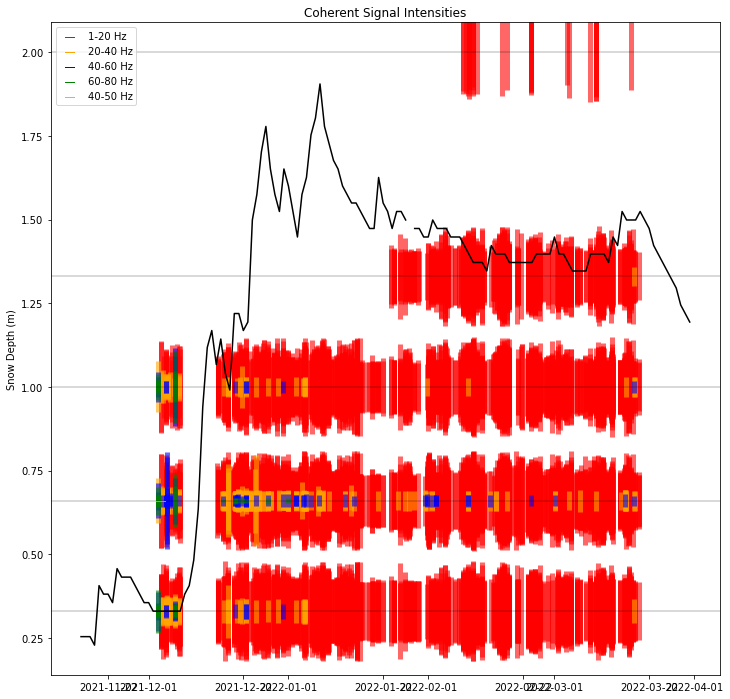

In [25]:
f, ax = plt.subplots(figsize = (12,12))
outlier = is_outlier(res.Power.values, thresh=5)
plotting = res.copy(deep = True)
plotting = plotting[~outlier]
# plotting = plotting.loc[(plotting.FreqRange == '20-40 Hz') | (plotting.FreqRange == '40-60 Hz') | (plotting.FreqRange == '60-80 Hz'), :]
s = plotting.Power
# s = np.log(s)
s = minmax_scale(s, (10,10000))
#ranking_dic = {0:(255/255,204/255,204/255),1:(255/255,153/255,153/255),2:(255/255,51/255,51/255),3:(204/255,0,0),4:(102/255,0,0)}
freq_dic = {'1-20 Hz':'red','20-40 Hz':'orange','40-60 Hz':'blue','60-80 Hz':'green','40-50 Hz': 'aqua'}#, '30-50 Hz':'yellow'}
colors = [freq_dic[i] for i in plotting.FreqRange]
ax.scatter(plotting.DateTime, plotting.Height, s = s, marker = "|", alpha = 0.6, linewidth = 5, c = colors)
for k,v in freq_dic.items():
    ax.scatter(plotting.DateTime.iloc[0], plotting.Height.iloc[0], s = 1, marker = "|", alpha = 1, linewidth = 10, c = v, label = k)

s = df[['SWE_m','SD_m']].copy()
s.loc[s.SD_m < 0, 'SD_m'] = np.nan
s.loc[(s.SD_m < 1) & (s.index > '2022-01-01'), 'SD_m'] = np.nan 
# s.loc[:,'SD_m'] = s.loc[:,'SD_m'].rolling(5).median()
s = s[s.index>'2021-11-15']
s = s.sort_index()
ax.plot(s.index.values, s.SD_m.values, color = 'black') #, c = s.SWE_m)
ax.set_ylabel('Snow Depth (m)')
ax.axhline(0.33, color = 'black', alpha = 0.2)
ax.axhline(0.66, color = 'black', alpha = 0.2)
ax.axhline(1, color = 'black', alpha = 0.2)
ax.axhline(1.33, color = 'black', alpha = 0.2)
ax.axhline(2, color = 'black', alpha = 0.2) #, label = 'Sensor Location' )
# ax.locator_params(axis = 'x', nbins = 4)
ax.legend(loc = 'upper left')
plt.title('Coherent Signal Intensities')

Text(0.5, 1.0, 'Coherent Signal Intensities')

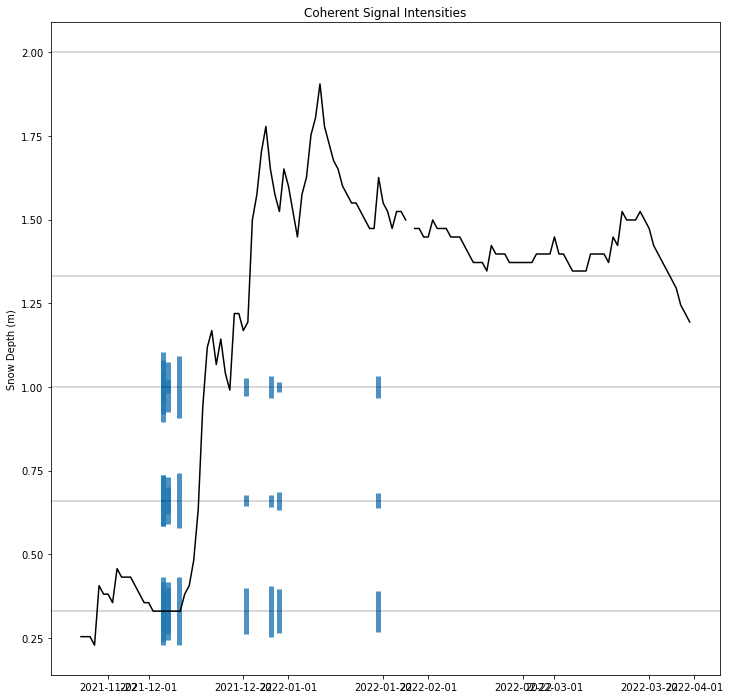

In [ ]:
f, ax = plt.subplots(figsize = (12,12))
outlier = is_outlier(full_res.Power.values, thresh=5)
plotting = full_res.copy(deep = True)
plotting = plotting[~outlier]
s = plotting.Power
# s = np.log(s)
s = minmax_scale(s, (10,5000))
ax.scatter(plotting.DateTime, plotting.Height, s = s, marker = "|", alpha = 0.8, linewidth = 5)

s = df[['SWE_m','SD_m']].copy()
s.loc[s.SD_m < 0, 'SD_m'] = np.nan
s.loc[(s.SD_m < 1) & (s.index > '2022-01-01'), 'SD_m'] = np.nan 
# s.loc[:,'SD_m'] = s.loc[:,'SD_m'].rolling(5).median()
s = s[s.index>'2021-11-15']
s = s.sort_index()
ax.plot(s.index.values, s.SD_m.values, color = 'black') #, c = s.SWE_m)
ax.set_ylabel('Snow Depth (m)')
ax.axhline(0.33, color = 'black', alpha = 0.2)
ax.axhline(0.66, color = 'black', alpha = 0.2)
ax.axhline(1, color = 'black', alpha = 0.2)
ax.axhline(1.33, color = 'black', alpha = 0.2)
ax.axhline(2, color = 'black', alpha = 0.2) #, label = 'Sensor Location' )
# ax.locator_params(axis = 'x', nbins = 4)
# ax.legend(loc = 'upper left')
plt.title('Coherent Signal Intensities')